In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# pip install ipython-autotime

In [3]:
%load_ext autotime

time: 0 ns (started: 2025-03-05 22:49:16 +03:00)


In [12]:
from modules.constants import TIMES

time: 0 ns (started: 2025-03-05 22:49:57 +03:00)


In [5]:
parameters_to_model = pd.read_csv('grid_search.csv')

time: 0 ns (started: 2025-03-05 21:11:55 +03:00)


Для наглядности, давайте работать с конкретной моделью, которая обучалась при 5 наблюдениях в тренировочной выборке

In [5]:
with open(f'models/52_model.pkl', 'rb') as f:
    cox = pickle.load(f)
df_train = pd.read_csv('Preprocessed/5_train_preprocessed.csv')

time: 1.31 s (started: 2025-03-05 22:49:27 +03:00)


Пока что посмотрим на один конкретный диск

In [7]:
df_one_disk = df_train[df_train['id'] == '45CHK11WFMYB']

time: 16 ms (started: 2025-03-05 21:11:57 +03:00)


In [4]:
pred = cox.predict(df_one_disk) 
timeshift = (df_one_disk['time'] - df_one_disk['time'].shift(-1)).fillna(0)
timeshift = timeshift[::-1].cumsum()[::-1]

NameError: name 'cox' is not defined

time: 266 ms (started: 2025-03-05 22:49:22 +03:00)


In [ ]:
def plot_surv(predictions, timeshift=None):
    plt.figure(figsize=(10, 6))
    
    for index, row in predictions.iterrows():
        plt.plot(predictions.columns.astype(float) + (timeshift[index] if not timeshift is None else 0), row, label=f'Наблюдение № {index}')
    
    plt.xlabel('День')
    plt.ylabel('Вероятность выживания')
    plt.title('Функции выживания объектов')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
plot_surv(pred.drop(['id', 'time'], axis='columns'), timeshift)

Данный класс реализует два варианта агрегации наблюдений.
1. **n_dist_agg** \
Пусть цепочка состоит из 3 наблюдений, тогда итоговое значение функции выживания рассчитывается как:
$$S(t) = \frac{S_1(t) + wS_2(t) + w^2S_3(t)}{1 + w + w^2}$$
w - произвольный вес, меньший единицы \
$S_i(2)$ - функция выживания предсказанная по i-ому наблюдению, если считать, что наблюдения отсортированы по убыванию актуальности \

2. **t_dist_agg** \
   Первый метод не учитывает, насколько наблюдения устарели. Кажется логичным, чтобы наблюдения произошедшие 1 день назад давали больший вклад, нежели события, произошедшие месяц назад. В данном случае формула имеет следующий вид:
   $$S(t) = \frac{S_1(t) + e^{\frac{t_2 - t_1}{s}}S_2(t) + e^{\frac{t_3 - t_1}{s}}S_3(t)}{1 + e^{\frac{t_2 - t_1}{s}} +  e^{\frac{t_3 - t_1}{s}}}$$
   s - параметр масштаба, чем он меньше, тем больше модель "чувствует" разницу во времени \
   $t_i$ - момент времени, в который былы предсказана функция выживания. Чем меньше, тем предсказание старее.

3. **geom_agg**
    $$S(t) = \alpha S(t, 0) + (1-\alpha)S_{agg}(t, -1) = \alpha S(t, 0) + \alpha (1-\alpha)S(t,-1) + \alpha (1-\alpha)^2S(t,-2) + ...
= \alpha (S(t, 0) + (1-\alpha)S(t,-1) + (1-\alpha)^2S(t,-2) + ... + (1-\alpha)^{n-1}S(t, -(n-1))) + (1-\alpha)^nS(t, -n)$$ \
АХТУНГ! Кажется геометрическая агрегация сломалась, после того как я добавил pred_corrected

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from lifelines import CoxTimeVaryingFitter
from lifelines.utils import concordance_index
from sksurv.metrics import integrated_brier_score
from metrics import ibs_remain
import pandas as pd
import numpy as np

class CoxTimeVaryingEstimator(BaseEstimator, RegressorMixin, CoxTimeVaryingFitter):
    def __init__(self, penalizer=0.0, l1_ratio=0.0, event_col="event", time_col = 'time', \
                 id_col='id', show_progress=False):
        '''
        penalizer, l1_ratio, show_progress - параметры CoxTimeVaryingFitter
        event_col, time_col, id_col - названия соответствующих колонок

        fit - принимает df без start/stop и обучает модель
        predict - принимает df без start/stop и шкалу times,
                возвращает функцию выживания для каждого наблюдения по временной шкале times.
                times обязана представлять собой непрерывную последовательность времён.
        get_survival_function - функция выживания для каждого переданного наблюдения
        '''

        self.penalizer = penalizer
        self.l1_ratio = l1_ratio
        self.event_col = event_col
        self.time_col = time_col
        self.id_col = id_col
        self.show_progress = show_progress

        super().__init__(penalizer = self.penalizer, l1_ratio = self.l1_ratio)

        
    def time_to_start_stop_cols(self, X, mode='chain'):
        '''
        mode = {chain, independent}
        '''
        X_copy = X.copy()

        X_copy = X_copy.sort_values(by=[self.id_col, self.time_col])
        if mode == 'chain':
            X_copy["start"] = X_copy[self.time_col] - X_copy.groupby(self.id_col)[self.time_col].transform('min')        
            X_copy["stop"] = X_copy.groupby(self.id_col)["start"].shift(-1)
            X_copy[self.event_col] = X_copy.groupby(self.id_col)[self.event_col].shift(-1)
        elif mode == 'independent':
            X_copy["start"] = 0        
            X_copy["stop"] = X_copy.groupby(self.id_col)[self.time_col].shift(-1)
            X_copy[self.event_col] = X_copy.groupby(self.id_col)[self.event_col].transform('max')
            # Удаление записей с NaN в stop (последние строки каждой группы)            
        else:
            raise ValueError("Wrong mode")
            
        # Удаление записей с NaN в stop (последние строки каждой группы)    
        X_copy = X_copy.dropna(subset=["stop"])
        X_copy = X_copy.drop(self.time_col, axis='columns')
    
        return X_copy

    def fit(self, X, y=None):
        self.train_transformed = self.time_to_start_stop_cols(X)
        self.fit_features = X.drop([self.id_col, self.time_col, self.event_col], axis='columns').columns

        super().fit(self.train_transformed, event_col = self.event_col,
                           start_col = 'start', stop_col = 'stop',
                           id_col = self.id_col,
                           show_progress=self.show_progress)
        return self

    def get_survival_function(self, X, times):
        '''
        На вход np.array
        На выход датафрейм. Можно наверное вообще это в просто predict превратить.
        '''
        baseline_survival = self.baseline_survival_
        
        fill_indicies = self.baseline_survival_.index.searchsorted(times, 'right') - 1
        fill_indicies = np.clip(fill_indicies, 0, max(fill_indicies))
        baseline_survival = self.baseline_survival_.iloc[fill_indicies, :]

        Y_pred  = super().predict_partial_hazard(X)
        survival_f = baseline_survival.values.reshape(-1)[None, :] ** Y_pred.values[:, None]
        survival_df = pd.DataFrame(survival_f, columns=times)
        # Эта строчка перестала быть нужна, так как моменты времени - это range(0, k)
        # Необходимо, чтобы названия столбцов действительно соответствовали моменту времени 
        # survival_df = survival_df.rename({i : t for i, t in zip(range(0, len(times)), times)}, axis='columns')
        
        return survival_df

    def predict(self, X, times=None):
        '''
        Датафрейм с признаками, id и time 
        '''
        # Сразу сделаем np.array
        X_np = X[self.fit_features].values
        X_values = self.get_survival_function(X_np, times=times)
        X_values = X_values.set_index(X.index)

        # Возвращаем на место id и time
        X_values[self.id_col] = X[self.id_col]
        X_values[self.time_col] = X[self.time_col]
        if self.event_col in X.columns:
            X_values[self.event_col] = X[self.event_col]
        
        return X_values

    def get_expected_time(self, X, times=None):
        survival_vec = self.predict(X, times=times)
        return self.get_expected_time_by_predictions(survival_vec, times)
        
    def get_expected_time_by_predictions(self, X_pred, times):
        survival_vec = X_pred.drop([self.id_col, self.time_col], axis='columns').values
        return np.trapz(y=survival_vec, x=times)

In [6]:
# Есть подозрение, что сделать этот класс универсальным будет сложно, поэтому пока что делаю интерфейс под свою модель
# В принципе, можно использовать методы n_dist_agg и t_dist_agg, тогда на пользователя перекладывается обязанность
# подготовить предсказания в правильном виде

class PredictionsAggregator():

    def __init__(self, model, mode):
        '''
        model - модель, у которой есть метод predict. Должен возвращать функции выживания.
        mode - t_dist, n_dist, geom, prob_dist, last. Отвечает за способ агрегации.
        time_col - название колонки со временем
        '''
        self.model = model
        self.mode = mode
        self.id_col = model.id_col
        self.time_col = model.time_col
        self.event_col = model.event_col
        self.baseline_survival_ = model.baseline_survival_
        self.EPS = 0.0001

    def get_expected_time(self, X, times=None):
        survival_vec = self.predict(X, times=times)
        return self.get_expected_time_by_predictions(survival_vec, times)
        
    def get_expected_time_by_predictions(self, X_pred, times=None):
        survival_vec = X_pred.drop([self.id_col, self.time_col], axis='columns').values
        return np.trapz(y=survival_vec, x=times if not times is None else survival_vec.columns)
        
    
    def predict(self, X_in, times, weight = None, scale = None, alpha=None):
        '''
        times - параметр-заглушка, нужен для совместимости с ibs_TV, в будущем надо будет избавиться
        weight - Параметр, который отвечает за вклад старых наблюдений в n_dist. Должен быть < 1.
        scale - параметр, который отвечает за вклад старых наблюдений в t_dist. В разных наборах данных
        может быть разное время между наблюдениями, где-то показания снимаются каждые 5 единиц времени, а где-то
        каждые 25. Так как метод t_dist основан на разнице во времени между наблюдениями, необходимо учитывать это.
        Так как методы являются взаимоисключающими, только один параметр может быть не-None.
        '''
        mode = self.mode
        if (not mode in ['n_dist', 't_dist', 'geom', 'prob_dist', 'last']):
            raise ValueError('Wrong mode!')
        if times is None:
            raise ValueError('Times must be non-None!')
            
        # Задаём параметры по умолчанию
        if mode=='n_dist' and (weight is None):
            self.weight = 1
        if mode=='t_dist' and (scale is None):
            self.scale = 1
        if mode=='geom' and (alpha is None):
            self.alpha = 0.5
            
        if self.event_col in X_in.columns:
            X = X_in.drop(self.event_col, axis='columns')
        X = X.sort_values(by = [self.id_col, self.time_col])
        
        timeshift = X.groupby(self.id_col)[self.time_col].transform('max') - X[self.time_col]  
        times_extended = self.extend_times(times, max(timeshift))
        
        pred = self.model.predict(X, times_extended)
        pred_corrected = self.correct_predictions(pred, max(times), np.array(timeshift))

        if mode == 'n_dist':
            pred_corrected.drop('surv_prob', axis='columns', inplace=True)
            return self.n_dist_agg(pred_corrected)
            
        if mode == 't_dist':
            pred_corrected.drop('surv_prob', axis='columns', inplace=True)
            return self.t_dist_agg(pred_corrected)

        if mode == 'geom':
            pred_corrected.drop('surv_prob', axis='columns', inplace=True)
            return self.geom_agg(pred_corrected)

        if mode == 'prob_dist':
            return self.prob_dist_agg(pred_corrected)

        if mode == 'last':
            pred_corrected.drop('surv_prob', axis='columns', inplace=True)
            return self.last_agg(pred_corrected)

    def extend_times(self, times, max_shift):
        '''
        Принимает на вход шкалу times и максимальный сдвиг относительно свежайшего наблюдения.
        Возвращает шкалу от 0 до max(times) + max_shift
        '''
        return np.arange(0, max_shift + max(times) + 1)

    def correct_predictions(self, X, max_times, timeshift):
        '''
        Выравниваем наблюдения по самому актуальному.
        X - данные
        max_times - длина times
        timeshift - положительная величина. Количество t, на которое наблюдение устарело относительно 
        самого последнего.
        '''
        X_res = X.drop([self.id_col, self.time_col], axis='columns').values
        row_indices = np.arange(X.shape[0])[:, None]
        col_indices = np.arange(max_times + 1) + timeshift[:, None]
        
        X_res = X_res[row_indices, col_indices]

        surv_prob = np.clip(X_res[:, 0], self.EPS, None)
        X_res = X_res / surv_prob[:, None]

        X_df = pd.DataFrame(X_res, columns=np.arange(max_times + 1), index=X.index)
        X_df[self.id_col] = X[self.id_col]
        X_df[self.time_col] = X[self.time_col]
        X_df['surv_prob'] = surv_prob
        return X_df
        
    def n_dist_agg_group(self, group):
            
        # Определяем степень удалённости n_dist для каждого наблюдения
        n_dist_values = np.arange(len(group))[::-1]  # [n-1, n-2, ..., 0]
        
        # Рассчитываем веса каждого ряда наблюдений
        weights = self.weight ** n_dist_values
        
        # Оставляем только колонки, которые отвечают за вероятности
        time_columns = group.columns[group.columns != self.id_col].tolist()
        numeric_data = group[time_columns]
        
        # Домножаем каждую строку на соответствующий вес
        weighted_data = numeric_data.multiply(weights, axis=0)
        
        # Вычисляем взвешенное среднее
        aggregated = weighted_data.sum(axis=0) / weights.sum()
        
        # Создаём итоговую строку с id
        return pd.DataFrame([aggregated], index=[group[self.id_col].iloc[0]]).reset_index(names=self.id_col)
            
    def n_dist_agg(self, X):
        '''
        Осуществляет агрегацию наблюдений, при которой предсказания с меньшим порядковым номером(более старые)
        дают меньший вклад
        X - датафрейм, который содержит значения функции выживания для различных наблюдений, 
            имеет колонки id_col и time_col  
        '''
        result_df = X.sort_values(by=self.time_col, ascending=True)
        result_df = result_df.drop(self.time_col, axis='columns')
        result_df = result_df.groupby(self.id_col, group_keys=False).apply(self.n_dist_agg_group)
        result_df = result_df.drop(['id'], axis='columns')
        return result_df

    def t_dist_agg_group(self, group):
            
        # Определяем степень удалённости t_dist для каждого наблюдения
        t_dist_values = group[self.time_col] -  max(group[self.time_col])
        
        # Рассчитываем веса каждого ряда наблюдений
        weights = np.exp(t_dist_values/self.scale)
        
        # Оставляем только колонки, которые отвечают за вероятности
        time_columns = group.columns[group.columns != self.id_col].tolist()
        numeric_data = group[time_columns]
        
        # Домножаем каждую строку на соответствующий вес
        weighted_data = numeric_data.multiply(weights, axis=0)
        
        # Вычисляем взвешенное среднее
        aggregated = weighted_data.sum(axis=0) / weights.sum()
        
        # Создаём итоговую строку с id
        return pd.DataFrame([aggregated], index=[group[self.id_col].iloc[0]]).reset_index(names=self.id_col)

    def t_dist_agg(self, X):
        '''
        Осуществляет агрегацию наблюдений, при которой предсказания соответствующие более старым наблюдениям дают меньший вклад.
        Старость определяется как время от самого актуального события
        X - датафрейм, который содержит значения функции выживания для различных наблюдений, 
            имеет колонки id_col и time_col  
        '''
        result_df = X.sort_values(by=self.time_col, ascending=True)
        result_df = result_df.groupby(self.id_col, group_keys=False).apply(self.t_dist_agg_group)
        result_df = result_df.drop(['time', 'id'], axis='columns')
        return result_df

    def geom_agg(self, X):
        '''
        Осуществляет геометрическую агрегацию.
        X - датафрейм, который содержит значения функции выживания для различных наблюдений, 
            имеет колонки id_col и time_col  
        '''
        result_df = X.copy().sort_values(by=self.time_col, ascending=False)
        powers = result_df.groupby('id').cumcount(ascending=True)
        result_df['weights'] = (1 - self.alpha) ** powers
        result_df.loc[powers != result_df.groupby('id').transform('size') - 1, 'weights'] *= self.alpha

        time_columns = result_df.drop([self.id_col, self.time_col, 'weights'], axis= 'columns').columns
        result_df.loc[:, time_columns] = result_df.loc[:, time_columns].mul(result_df['weights'], axis = 'rows')
        result_df = result_df.groupby(self.id_col)[time_columns].sum().div(result_df.groupby(self.id_col)['weights'].sum(), axis='rows')
        result_df = result_df.reset_index(names = self.id_col)
        result_df.loc[:,'time'] = 0 # заглушка, потому что это колонка не используется, в будущем можно сделать настоящей
        
        return result_df

    def prob_dist_agg(self, X):
        '''
        Осуществляет агрегацию, основанную на значении функции выживания.
        X - датафрейм, который содержит значения функции выживания для различных наблюдений, 
            колонки id_col и time_col, а также колонку surv_prob, в которой хранится значение
            вероятности выживания данного наблюдения, в момент самого актуального наблюдения группы. 
        '''
        time_columns = X.drop([self.id_col, self.time_col, 'surv_prob'], axis= 'columns').columns
        pred_mul = X.copy()
        pred_mul.loc[:, time_columns] = X.loc[:, time_columns].mul(X['surv_prob'], axis = 'rows')
        result_df = pred_mul.groupby(self.id_col)[time_columns].sum().div(pred_mul.groupby(self.id_col)['surv_prob'].sum(), axis='rows')
        result_df = result_df.reset_index(names = self.id_col)
        result_df.loc[:,'time'] = X[X.groupby(self.id_col)['time'].transform('max') == X['time']]['time'].reset_index(drop=True)
        
        return result_df

    def last_agg(self, X):
        return X[X[self.time_col] == X.groupby(self.id_col)[self.time_col].transform('max')]

time: 0 ns (started: 2025-03-05 22:49:34 +03:00)


In [18]:
# cox = CoxTimeVaryingEstimator(penalizer=0.1, l1_ratio=0.1)
# cox.fit(df_train)

time: 0 ns (started: 2025-03-05 21:18:20 +03:00)


In [19]:
from modules.metrics_TV import prepare_data_for_test

X_train, events, durations = prepare_data_for_test(df_train, mode='agg')

time: 62 ms (started: 2025-03-05 21:18:27 +03:00)


In [20]:
pred_agg = PredictionsAggregator(cox, mode='last')
# X = pred_agg.predict(df_train, times=TIMES)
# X = pred_agg.predict(df_train[df_train['id'].isin(['Z3004NAP', 'JK11A8B9J9L2AF'])].reset_index(), times=None)


time: 0 ns (started: 2025-03-05 21:18:28 +03:00)


In [ ]:
X.min()

In [ ]:
# cox_new = CoxTimeVaryingEstimator(penalizer = 0.01, l1_ratio = 0.01)
# cox_new.fit(df_train)

In [ ]:
pred_agg.predict(X_test, TIMES)

In [13]:
from modules.metrics_TV import get_ci_and_ibs
from modules.constants import TIMES
get_ci_and_ibs(cox, X_train, TIMES, mode='independent')

NameError: name 'X_train' is not defined

time: 15 ms (started: 2025-03-05 22:50:05 +03:00)


pred_agg last:(0.8347599480108897, 0.4498703773153591)

In [141]:
X_selected_disk = df_train[df_train['id'] == '45CHK11WFMYB'].reset_index(drop=True)
pred = cox_new.predict(X_selected_disk, times=TIMES).drop(['id', 'time'], axis='columns')

NameError: name 'cox_new' is not defined

time: 15 ms (started: 2025-03-05 19:19:56 +03:00)


In [21]:
def plot_results(model, X, disk_id, mode='n_dist', times=None, shift_observ=True):

    X_selected_disk = X[X['id'] == disk_id].reset_index(drop=True)

    pred = model.predict(X_selected_disk, times=times).drop(['id', 'time', 'event'], axis='columns')
    
    timeshift = (X_selected_disk['time'] - X_selected_disk['time'].shift(-1)).fillna(0)
    timeshift = timeshift[::-1].cumsum()[::-1].reset_index(drop='True')

    pred_agg = PredictionsAggregator(model, mode=mode)
    X_agg = pred_agg.predict(X_selected_disk.reset_index(drop='True'), times=times)
    
    plt.figure(figsize=(10, 6))
    for index, row in pred.iterrows():
        try:
            plt.plot(pred.columns.astype(float) + (timeshift[index] if shift_observ else 0), row, label=f'Наблюдение № {index}')
        except:
            pass

    X_agg = X_agg.drop(['id', 'time'], axis='columns')
    plt.plot(X_agg.columns.astype(float), X_agg.values.reshape(-1), linestyle='dashed' ,label=f'Агрегат')

    plt.xlabel('День')
    plt.ylabel('Вероятность выживания')
    plt.title(f'Функции выживания объектов, mode={mode}')
    plt.legend()
    plt.grid(True)
    plt.show()

time: 0 ns (started: 2025-03-05 22:50:36 +03:00)


In [30]:
cox.predict_partial_hazard(df_train)

C:\ProgramData\Anaconda3\envs\3_11_test\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


0         15.993655
1         11.290748
2         16.333237
3         10.804597
4         16.782265
            ...    
103857     9.067806
103858    10.629724
103859     9.331315
103860     9.387511
103861    72.911341
Length: 103862, dtype: float64

time: 78 ms (started: 2025-03-05 22:55:33 +03:00)


In [23]:
def plot_results(model, X, disk_id, mode='n_dist', times=None, shift_observ=True):

    X_selected_disk = X[X['id'] == disk_id].reset_index(drop=True)

    pred = model.predict(X_selected_disk, times=times).drop(['id', 'time', 'event'], axis='columns')
    
    timeshift = (X_selected_disk['time'] - X_selected_disk['time'].shift(-1)).fillna(0)
    timeshift = timeshift[::-1].cumsum()[::-1].reset_index(drop='True')

    pred_agg = PredictionsAggregator(model, mode=mode)
    X_agg = pred_agg.predict(X_selected_disk.reset_index(drop='True'), times=times)
    
    plt.figure(figsize=(10, 6))
    for index, row in pred.iterrows():
        try:
            plt.plot(pred.columns.astype(float) + (timeshift[index] if shift_observ else 0), row, label=f'Наблюдение № {index}')
        except:
            pass

    X_agg = X_agg.drop(['id', 'time'], axis='columns')
    # plt.plot(X_agg.columns.astype(float), X_agg.values.reshape(-1), linestyle='dashed' ,label=f'Агрегат')

    plt.xlabel('День')
    plt.ylabel('Вероятность выживания')
    plt.title(f'Функции выживания объектов')
    plt.legend()
    plt.grid(True)
    plt.show()

time: 0 ns (started: 2025-03-05 22:51:24 +03:00)


In [15]:
# df_train_selected = df_train[df_train['id'].isin(['0F112CC45', '13H2B97AS', '45CHK11WFMYB'])]

time: 0 ns (started: 2025-03-05 22:50:11 +03:00)


In [81]:
baseline_cum_hazard = cox.baseline_cumulative_hazard_ ** 1
times = baseline_cum_hazard.index.values
cumulative_hazard = baseline_cum_hazard.values.flatten()
instantaneous_hazard = np.diff(cumulative_hazard, prepend=0)

time: 0 ns (started: 2025-03-05 23:22:35 +03:00)


Text(0, 0.5, 'Риск')

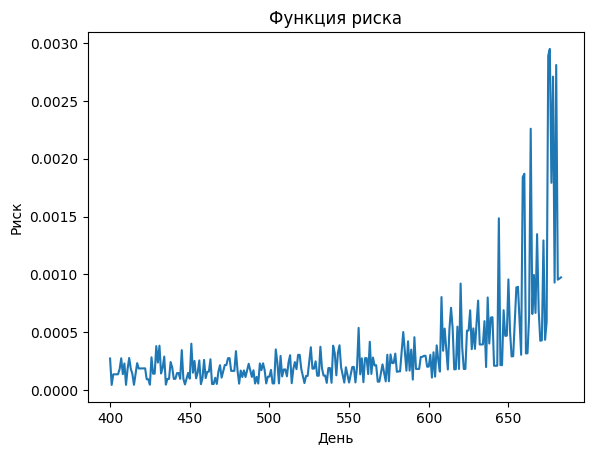

time: 141 ms (started: 2025-03-05 23:23:28 +03:00)


In [84]:
START_DAY = 400
x = np.arange(len(instantaneous_hazard[START_DAY:])) + START_DAY
plt.plot(x,instantaneous_hazard[START_DAY:])
plt.title('Функция риска')
plt.xlabel('День')
plt.ylabel('Риск')

In [90]:
df_train[df_train['id'] == '45CHK11WFMYB'].iloc[:,:10]

,time,id,capacity_bytes,event,smart_1_raw,smart_3_raw,smart_4_raw,smart_9_raw,smart_12_raw,smart_183_raw
78,0,45CHK11WFMYB,0.727777,0,-0.449779,3.191285,-0.118562,-1.586993,-0.608813,-0.010971
79,122,45CHK11WFMYB,0.727777,0,-0.449779,3.191285,-0.118562,-1.394519,-0.608813,-0.010971
80,193,45CHK11WFMYB,0.727777,0,-0.449779,3.191285,-0.118562,-1.282429,-0.608813,-0.010971
81,203,45CHK11WFMYB,0.727777,0,-0.449779,3.191285,-0.118562,-1.266642,-0.608813,-0.010971
82,294,45CHK11WFMYB,0.727777,0,-0.449779,3.191285,-0.118562,-1.123043,-0.608813,-0.010971
83,382,45CHK11WFMYB,0.727777,1,-0.449779,3.191285,-0.118562,-0.984049,-0.608813,-0.010971


time: 15 ms (started: 2025-03-06 01:54:16 +03:00)


In [19]:
SHIFT_FLAG = False
MODE = 'last'
df_train_last = df_train[df_train['time'] != df_train.groupby('id')['time'].transform('max')]

time: 15 ms (started: 2025-03-05 22:50:24 +03:00)


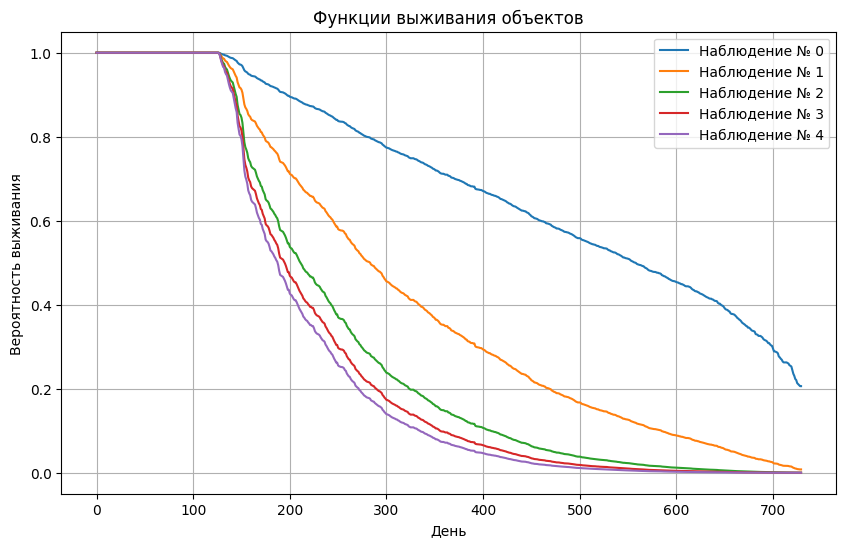

time: 266 ms (started: 2025-03-05 22:51:26 +03:00)


In [24]:
plot_results(cox, df_train_last, '45CHK11WFMYB', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

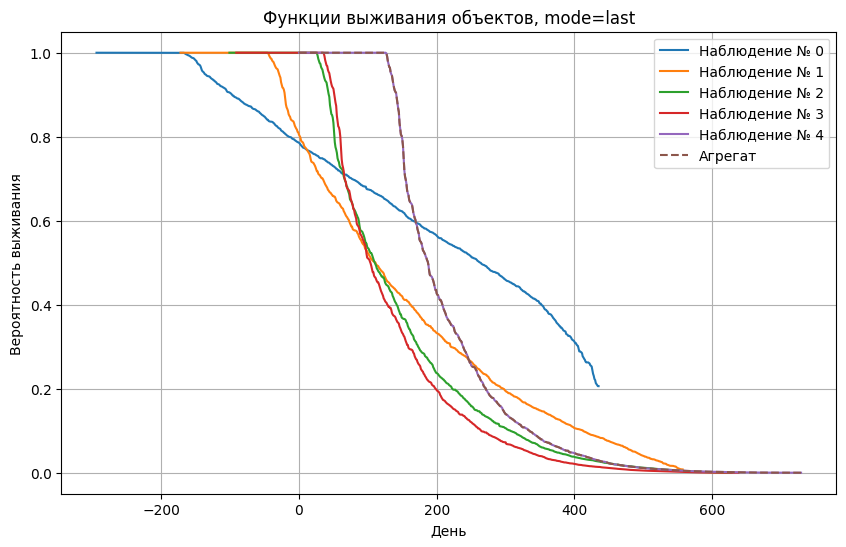

time: 203 ms (started: 2025-03-05 22:50:12 +03:00)


In [18]:
plot_results(cox, df_train_last, '45CHK11WFMYB', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

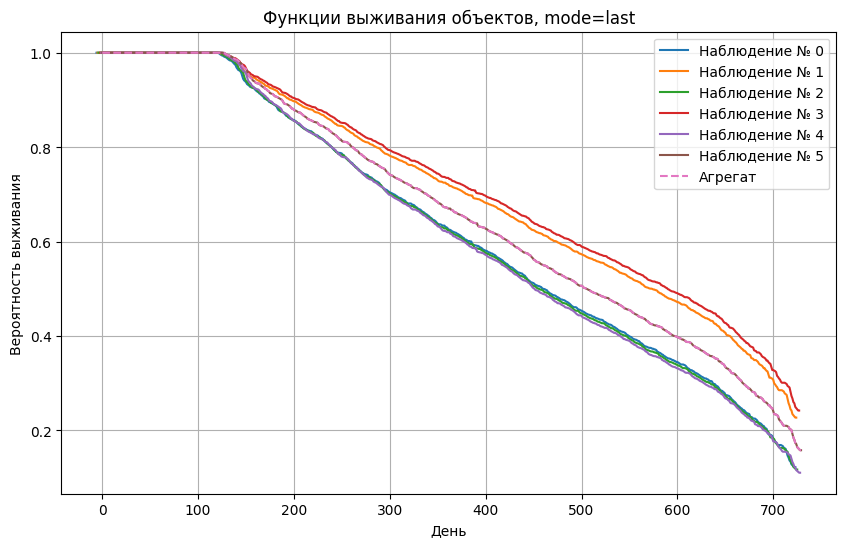

time: 187 ms (started: 2025-03-05 19:33:21 +03:00)


In [234]:
plot_results(cox, df_train_last, '0F112CC45', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

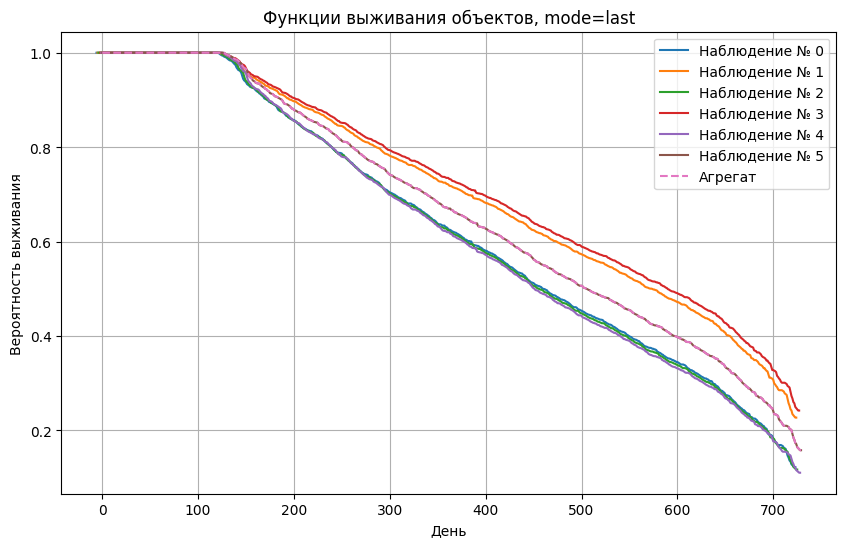

time: 187 ms (started: 2025-03-05 19:33:21 +03:00)


In [235]:
plot_results(cox, df_train_last, '0F112CC45', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

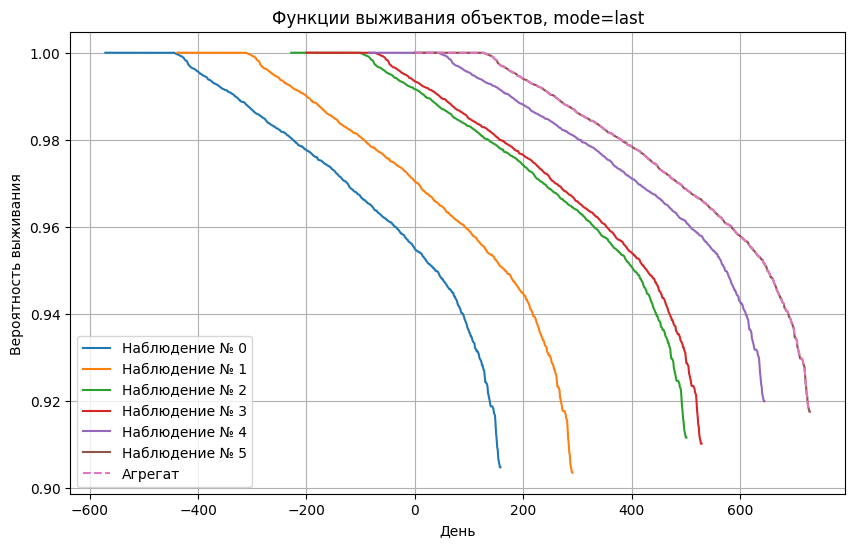

time: 188 ms (started: 2025-03-05 19:33:22 +03:00)


In [236]:
plot_results(cox, df_train_last, '13H2B97AS', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

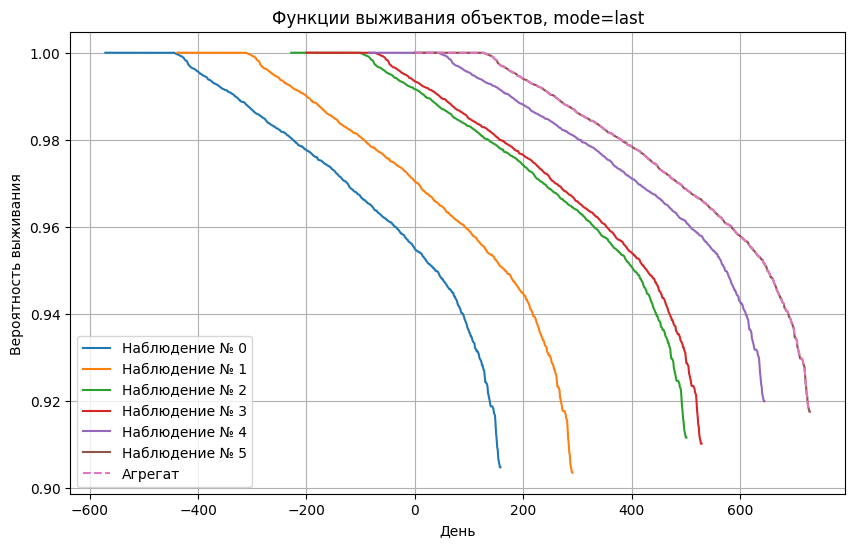

time: 187 ms (started: 2025-03-05 19:33:23 +03:00)


In [237]:
plot_results(cox, df_train_last, '13H2B97AS', mode=MODE, times=TIMES, shift_observ= SHIFT_FLAG)

# Точечные оценки

In [1]:
from lifelines import CoxTimeVaryingFitter
from modules.model import CoxTimeVaryingEstimator, PredictionsAggregator
from modules.constants import TIMES
from modules.metrics import ibs_remain
from modules.metrics_TV import get_ci_and_ibs
from lifelines.utils import concordance_index
import pandas as pd

In [142]:
TRAIN_SAMPLES = 5
df_train_n = pd.read_csv(f'Preprocessed/{TRAIN_SAMPLES}_train_preprocessed.csv')

df_test_1 = pd.read_csv(f'Preprocessed/{TRAIN_SAMPLES}_1_test_preprocessed.csv')
df_test_25 = pd.read_csv(f'Preprocessed/{TRAIN_SAMPLES}_1_test_preprocessed.csv')

In [121]:
cox = CoxTimeVaryingEstimator(l1_ratio = 0.5, penalizer=0.5)
cox.fit(df_train_n)

CoxTimeVaryingEstimator(l1_ratio=0.5, penalizer=0.5)

In [147]:
df_train_n = df_train_n.sort_values(by=['id', 'time'], ascending=False)
X_last_sample = df_train_n.groupby('id').head(2)

In [165]:
X_last_sample = X_last_sample.sort_values(by=['id', 'time']) 
df_train_n = df_train_n.sort_values(by=['id', 'time']) 


Интересные получились результаты. Как будто именно когда происходит агрегация, есть ошибка.

In [166]:
get_ci_and_ibs(cox, X_last_sample, TIMES, 'agg')

(730,) (17356, 730)


(0.821799603295668, 0.5561488268229045)

In [167]:
pred_agg_last = PredictionsAggregator(cox, mode='last')
get_ci_and_ibs(pred_agg_last, df_train_n, TIMES, 'agg')

(0.8213149433512602, 0.5567582481379826)

In [168]:
pred_agg_last = PredictionsAggregator(cox, mode='last')
get_ci_and_ibs(pred_agg_last, X_last_sample, TIMES, 'agg')

(0.8217996450022148, 0.556715730354865)

In [169]:
pred_agg_last = PredictionsAggregator(cox, mode='prob_dist')
get_ci_and_ibs(pred_agg_last, X_last_sample, TIMES, 'agg')

(0.8217996450022148, 0.556715730354865)

In [134]:
def prepare_data_for_test(df, id_col='id', time_col='time', event_col='event', mode = 'independent'):
    '''
    На вход принимает датасет вида id_col, time_col, event_col, признаки
    На выходе датафрейм, events, durations
    У датафрейма отсечены самые последние наблюдения соответствующие каждому диску
    '''
    durations = df.groupby(id_col)[time_col].transform('max') - df[time_col]
    events = df.groupby(id_col)[event_col].transform('max')[durations != 0]
    result_df = df.loc[durations != 0, :]
    durations = durations[durations != 0]
    if mode=='agg':
        last_observ = result_df[time_col] == result_df.groupby(id_col)[time_col].transform('max')
        events = events[last_observ]
        durations = durations[last_observ]
    return result_df, events.astype('bool'), durations

In [135]:
X_test, test_events, test_durations = prepare_data_for_test(df_train_n, mode = 'agg')
survival_test = pd.DataFrame()
survival_test['event'] = test_events
survival_test['duration'] = test_durations

X_pred = pred_agg_last.predict(X_test, TIMES)

survival_estim = X_pred.drop([pred_agg_last.id_col, pred_agg_last.time_col], axis='columns')
ibs = ibs_remain(
    None, 
    survival_test.to_records(index=False),  
    survival_estim, 
    TIMES 
)
print(ibs)

0.5106745726300355


In [136]:
my_durations = df_train_n.groupby('id')['time'].transform('max') - df_train_n['time']
my_events = df_train_n.groupby('id')['event'].transform('max')[my_durations != 0]
df_x = df_train_n.loc[my_durations != 0]
my_durations = my_durations[my_durations != 0]
my_durations = my_durations[df_x['time'] == df_x.groupby('id')['time'].transform('max')]
my_events = my_events[df_x['time'] == df_x.groupby('id')['time'].transform('max')].astype('bool')

In [137]:
(survival_test['duration'] == my_durations).all(), (survival_test['event'] == my_events).all(), (df_x == X_test).all().all()

(True, True, True)

In [138]:
my_estim = pred_agg_last.predict(df_x, TIMES).drop(['time', 'id'], axis = 'columns')

my_survival_test = pd.DataFrame()
my_survival_test['event'] = my_events
my_survival_test['duration'] = my_durations

In [139]:
ibs = ibs_remain(
    None, 
    my_survival_test.to_records(index=False),  
    my_estim, 
    TIMES 
)
ibs

0.5106745726300355

In [140]:
last_durations = X_last_sample.groupby('id')['time'].transform('max') - X_last_sample['time']
last_events = X_last_sample.groupby('id')['event'].transform('max')[last_durations != 0]
df_lastx = X_last_sample.loc[last_durations != 0]
last_durations = last_durations[last_durations != 0]
last_durations = last_durations[df_lastx['time'] == df_lastx.groupby('id')['time'].transform('max')]
last_events = last_events[df_lastx['time'] == df_lastx.groupby('id')['time'].transform('max')].astype('bool')

In [141]:
last_durations, my_durations

(89002     30
 17110     28
 71725      8
 96602     25
 17104     23
           ..
 85620      1
 103216     1
 54232      1
 103832     1
 103848     1
 Name: time, Length: 17356, dtype: int64,
 73394     1
 97919     1
 90592     1
 96735     1
 87031     1
          ..
 51572     5
 100383    3
 102351    3
 102243    2
 102639    2
 Name: time, Length: 17356, dtype: int64)

Эксперимент показывает, что ошибка должно быть кроется в predict. Мне так кажется.

# Не используется 

In [115]:
def create_start_stop(df):
    df['start'] = df['time'] - df.groupby('id')['time'].transform('min')
    df['stop'] = df.groupby('id')['start'].shift(-1)
    df['event'] = df.groupby('id')['event'].shift(-1)
    return df.dropna(subset=["stop"])

time: 0 ns (started: 2025-03-06 14:58:34 +03:00)


In [123]:
cox = CoxTimeVaryingFitter(l1_ratio = 0.5, penalizer=0.5)
df_train_start_stop = create_start_stop(df_train_n)
cox.fit(df_train_start_stop, id_col='id', event_col='event')

<lifelines.CoxTimeVaryingFitter: fitted with 511180 periods, 17356 subjects, 36994 events>

time: 3min 9s (started: 2025-03-06 15:03:50 +03:00)


In [124]:
cox.predict(df_train_start_stop)

AttributeError: 'CoxTimeVaryingFitter' object has no attribute 'predict'

time: 31 ms (started: 2025-03-06 15:14:13 +03:00)


In [ ]:
def get_usual_cox_ibs(cox, X):

    survival_test = pd.DataFrame()
    durations = X.groupby('id')['time'].transform('max') - X['time']
    events = X['events'].groupby('id')['event'].transform('max')[durations != 0]
    X_test = X.loc[durations != 0:]
    durations = durations[durations != 0]
    survival_test['event'] = test_events
    survival_test['duration'] = test_durations

    # Если параметр times не передаётся явно, то интегрируем по всему временному интервалу
    if times is None:
        times = np.array(model.baseline_survival_.index) 

    survival_estim = cox.predict(X_test).drop([model.id_col, model.time_col], axis='columns')
    
    ibs = ibs_remain(
        None,
        survival_test.to_records(index=False),  
        survival_estim, 
        times 
    )
    return ibs